In [1]:
import calour as ca 
import pandas as pd
from scipy import stats
import seaborn as sns
from itertools import combinations
%matplotlib inline

In [2]:
from sklearn.ensemble import RandomForestClassifier
from calour.training import plot_roc, plot_cm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score
from scipy.sparse import csr_matrix

In [3]:
pd.set_option('max_colwidth',500)
pd.set_option('max_rows',500)

In [4]:
from itertools import permutations
from matplotlib.backends.backend_pdf import PdfPages

# function

In [5]:

def classification(exp,field,col):
    ''' 
    exp : calour exp
    field:
    col: str,colunms of impF
    
    retrun:   res: DataFrame,the results of classification
              impF: DataFrame,each features importances
    '''
    
    rskf = StratifiedKFold(n_splits=5,random_state=0)

    rs=[]
    for i, (train_index, test_index) in enumerate(rskf.split(exp.data,
                                              exp.sample_metadata[field])):
            x_train = exp.data[train_index]
            y_train =exp.sample_metadata[field][train_index]
            rfc = RandomForestClassifier(random_state=0)
            rfc.fit(x_train, y_train)

            x_test = exp.data[test_index]
            y_test = exp.sample_metadata[field][test_index]
            r = pd.DataFrame(rfc.predict_proba(x_test), columns=rfc.classes_)
            r.insert(2, 'Y_TRUE', y_test.tolist())
            r.insert(3, 'CV', i)
            rs.append(r)
    res=pd.concat(rs)

    impF=pd.DataFrame(data=rfc.feature_importances_,index=exp.to_pandas(sparse=False).columns,columns=[col])
    
    return res,impF

In [6]:
ca.set_log_level(11)

# read data

In [7]:
exp=ca.read_amplicon('gastritis-and-GC-data.tsv',
                     'gastritis-and-GC-metadata.tsv',
                     data_file_type='tsv',normalize=100,min_reads=None)

2022-04-15 00:15:39 INFO loaded 586 samples, 2026 features
2022-04-15 00:15:39 WARNING These have metadata but do not have data - dropped (90): {'SRR3194032', 'SRR3195190', 'SRR3194103', 'SRR3194020', 'SRR3194137', 'SRR3194124', 'SRR3194119', 'SRR3194030', 'SRR3194141', 'SRR3195185', 'SRR3194108', 'SRR3195184', 'SRR3194110', 'SRR3194003', 'SRR3194116', 'SRR3194149', 'SRR3194097', 'SRR3194101', 'SRR3194025', 'SRR3194128', 'SRR3194033', 'SRR3194151', 'SRR3194154', 'SRR3194098', 'SRR3193967', 'SRR3194099', 'SRR3194017', 'SRR3194100', 'SRR3194146', 'SRR3194129', 'SRR3194132', 'SRR3194016', 'SRR3193964', 'SRR3194112', 'SRR3194125', 'SRR3194113', 'SRR3194015', 'SRR3193975', 'SRR3194034', 'SRR3194131', 'SRR3194121', 'SRR3194095', 'SRR3194036', 'SRR3194117', 'SRR3194035', 'SRR3195186', 'SRR3194118', 'SRR3194009', 'SRR3195188', 'SRR3193996', 'SRR3194024', 'SRR3194022', 'SRR3194147', 'SRR3194135', 'SRR3194142', 'SRR3194037', 'SRR3195187', 'SRR3194114', 'SRR3194018', 'SRR3194123', 'SRR3194105', '

In [8]:
exp.feature_metadata.head(2)

,_feature_id
Unnamed: 0,
1000477,1000477
1001155,1001155


In [9]:
exp.sample_metadata['Sample_type'].value_counts()

gastric mucosa    586
Name: Sample_type, dtype: int64

In [10]:
exp.sample_metadata['Diagnosis'].value_counts()

gastritis         301
gastric cancer    285
Name: Diagnosis, dtype: int64

In [11]:
exp.sample_metadata['BioProject'].value_counts()

PRJNA481413    230
PRJNA375772    186
PRJEB26931     125
PRJEB21104      45
Name: BioProject, dtype: int64

In [12]:
exp_ggc=exp.filter_samples('BioProject',
                            ['PRJEB26931','PRJNA375772','PRJNA481413']).filter_samples('Sample_type','gastric fluid',negate=True).filter_samples('Diagnosis',
                                                                                                    ['gastritis','gastric cancer'])
exp_ggc


AmpliconExperiment with 541 samples, 2026 features

In [13]:
exp_ggc.sample_metadata['Diagnosis'].value_counts()

gastric cancer    275
gastritis         266
Name: Diagnosis, dtype: int64

In [14]:
exp_ggc.sample_metadata.pivot_table(values='Name',index='Study',columns='Diagnosis',aggfunc='count')

Diagnosis,gastric cancer,gastritis
Study,,
PRJEB26931,84,41
PRJNA375772_Inner_Mongolia,36,56
PRJNA375772_Xi_an,40,54
PRJNA481413,115,115


In [15]:
exp_ggc.sample_metadata['Study'].value_counts()

PRJNA481413                   230
PRJEB26931                    125
PRJNA375772_Xi_an              94
PRJNA375772_Inner_Mongolia     92
Name: Study, dtype: int64

In [16]:
exp_ggc

AmpliconExperiment with 541 samples, 2026 features

In [17]:
p26931=exp_ggc.filter_samples('BioProject','PRJEB26931')
p375772_xian=exp_ggc.filter_samples('Study','PRJNA375772_Xi_an')
p375772_im=exp_ggc.filter_samples('Study','PRJNA375772_Inner_Mongolia')
p481413=exp_ggc.filter_samples('BioProject','PRJNA481413')
p26931,p375772_xian,p375772_im,p481413

(AmpliconExperiment with 125 samples, 2026 features,
 AmpliconExperiment with 94 samples, 2026 features,
 AmpliconExperiment with 92 samples, 2026 features,
 AmpliconExperiment with 230 samples, 2026 features)

In [18]:
exp_gg=exp_ggc

# classification

In [19]:
class_res=[]
imp_otu=[]

for dataset in ['PRJEB26931',
                "PRJNA375772_Xi_an",
                'PRJNA375772_Inner_Mongolia','PRJNA481413']:
    data=exp_gg.filter_samples('Study',dataset)
    resc,important=classification(data,'Diagnosis',dataset)
    resc['Study']=dataset
   # plot_roc(resc,title=dataset)
    class_res.append(resc)
    imp_otu.append(important)
imp_OTU=pd.concat(imp_otu,axis=1)
classify_res=pd.concat(class_res)

/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selec

In [20]:
def plot_roc_curve(result, classes=None, title='ROC', col='red',cv=True, cmap=None, ax=None):
    
    from matplotlib import pyplot as plt
    if cmap is None:
        cmap = plt.cm.Dark2
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=1)

    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()

    #col = dict(zip(classes, itertools.cycle(cmap.colors))) ##
    study=result['Study'].unique().tolist()[0]
    
    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                    logger.warning(
                        'The cross validation fold %r is skipped because the true positive rate or '
                        'false positive rate computation failed. This is likely because you '
                        'have either no true positive or no negative samples in this '
                        'cross validation for the class %r' % (grp, cls))
                    continue
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col,
                    label='{0} ({1:.2f} $\\pm$ {2:.2f})'.format(study, mean_auc, std_auc),
                    lw=2, alpha=.8) #

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col, alpha=.4)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    #ax.legend(loc="lower right")
    ax.legend(title='',loc="lower right",frameon=False,prop={'size':7.5})
              #bbox_to_anchor=(1.05,1.0),
              #borderaxespad = 0.)
    return ax, mean_auc if cv else roc_auc

In [21]:
cmap = plt.cm.tab10
colmap = dict(zip(['PRJEB26931',
                   "PRJNA375772_Xi_an",
                'PRJNA375772_Inner_Mongolia','PRJNA481413'], cmap.colors))

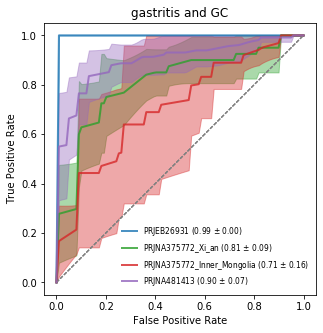

In [22]:
fig, ax = plt.subplots(figsize=(5,5))
for dataset in ['PRJEB26931',
                "PRJNA375772_Xi_an",
                'PRJNA375772_Inner_Mongolia','PRJNA481413']:
                   
    plot_roc_curve(classify_res.query('Study=="%s"' %dataset),col=colmap[dataset],
                    title='gastritis and GC',
                    classes=['gastric cancer'],ax=ax)
plt.savefig('figures/withhp-each-study-classfication-roc-plot.pdf')    

In [23]:
exp_gg.sample_metadata['Study'].value_counts()

PRJNA481413                   230
PRJEB26931                    125
PRJNA375772_Xi_an              94
PRJNA375772_Inner_Mongolia     92
Name: Study, dtype: int64

In [24]:
# trained on dataset1，predict dataset2

def OTO_RFC(dataset1,dataset2,field='Diagnosis'):
    skf = StratifiedKFold(n_splits=5, random_state=0)
    rs=[]
    for i, (train_index, test_index) in enumerate(skf.split(dataset1.data,
                                              dataset1.sample_metadata[field])):
            x_train = dataset1.data[train_index]
            y_train =dataset1.sample_metadata[field][train_index]
            rfc = RandomForestClassifier(n_estimators=1000,random_state=0)
            rfc.fit(x_train, y_train)
            x_test = dataset1.data[test_index]
            y_test = dataset1.sample_metadata[field][test_index]
            r = pd.DataFrame(rfc.predict_proba(x_test), columns=rfc.classes_)
            r.insert(2, 'Y_TRUE', y_test.tolist())
            r.insert(3, 'CV', i)
            rs.append(r)
    DS1_res=pd.concat(rs)
    

    x_test2 =dataset2.data
    y_test2 =dataset2.sample_metadata['Diagnosis']

    DS2_res = pd.DataFrame(rfc.predict_proba(x_test2), columns=rfc.classes_)
    DS2_res.insert(2, 'Y_TRUE', y_test2.tolist())
    DS2_res.insert(3, 'CV', 0)
    
    impF=pd.DataFrame(data=rfc.feature_importances_,index=dataset1.to_pandas(sparse=False).columns,columns=['imp_score'])
    impF.sort_values(by='imp_score',ascending=False)
    impF_list=impF.index.tolist()
   
    return DS1_res,DS2_res,impF_list


In [25]:
# calculate ROC

def ca_roc(result, cv=True,classes=None):
    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()


    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                    logger.warning(
                        'The cross validation fold %r is skipped because the true positive rate or '
                        'false positive rate computation failed. This is likely because you '
                        'have either no true positive or no negative samples in this '
                        'cross validation for the class %r' % (grp, cls))
                    continue
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
    return mean_auc if cv else roc_auc  

In [26]:
def plot_roc_curve2(result, classes=None, title='ROC', col='red',cv=True, cmap=None, ax=None):
    
    from matplotlib import pyplot as plt
    if cmap is None:
        cmap = plt.cm.Dark2
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=1)

    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()

    #col = dict(zip(classes, itertools.cycle(cmap.colors))) ##
    #study=result['Study'].unique().tolist()[0]
    
    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                y_true = df['Y_TRUE'].values == cls
                fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                    logger.warning(
                        'The cross validation fold %r is skipped because the true positive rate or '
                        'false positive rate computation failed. This is likely because you '
                        'have either no true positive or no negative samples in this '
                        'cross validation for the class %r' % (grp, cls))
                    continue
                mean_tpr = np.interp(mean_fpr, fpr, tpr)
                tprs.append(mean_tpr)
                tprs[-1][0] = 0.0
                roc_auc = auc(mean_fpr, mean_tpr)
                aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col,
                    label='AUC: ({0:.2f} $\\pm$ {1:.2f})'.format(mean_auc, std_auc),
                    lw=2, alpha=.8) #

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col, alpha=.4)
        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    #ax.legend(loc="lower right")
    ax.legend(title='',loc="lower right",frameon=False,prop={'size':7.5})
              #bbox_to_anchor=(1.05,1.0),
              #borderaxespad = 0.)
    return ax, mean_auc if cv else roc_auc

## classfication by diff otu

In [27]:
D26931=exp_gg.filter_samples('BioProject','PRJEB26931')
D375772_xian=exp_gg.filter_samples('Study','PRJNA375772_Xi_an')
D375772_im=exp_gg.filter_samples('Study','PRJNA375772_Inner_Mongolia')
D481413=exp_gg.filter_samples('BioProject','PRJNA481413')
exp_gg,D26931,D375772_xian,D375772_im,D481413

(AmpliconExperiment with 541 samples, 2026 features,
 AmpliconExperiment with 125 samples, 2026 features,
 AmpliconExperiment with 94 samples, 2026 features,
 AmpliconExperiment with 92 samples, 2026 features,
 AmpliconExperiment with 230 samples, 2026 features)

In [28]:
diff_otu = pd.read_csv('diff-otu-DESeq2.csv')
diff_otu.head()

,Unnamed: 0,diff_otu,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Study,CI_low,CI_hig,Significant,taxonomy,Taxonomy,ID_Taxonomy,Taxon,diff_oral,Taxon_oral,taxon_oral,absFC
0,80,359079,28.337522,3.686162,0.374837,9.834042,8.032871e-23,6.426297e-20,PRJNA375772_Xi_an,2.625373,4.746950,GC enriched,k__Bacteria; p__Firmicutes; c__Bacilli; o__Lactobacillales; f__Streptococcaceae; g__Streptococcus; s__anginosus,s__anginosus,359079 \n s__anginosus,359079; s__anginosus,*,* 359079; s__anginosus,* 359079 \n s__anginosus,3.686162
1,108,4318284,22.016874,3.417849,0.446139,7.660948,1.845652e-14,3.281160e-12,PRJNA375772_Xi_an,2.155275,4.680423,GC enriched,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Veillonellaceae; g__Dialister; s__,g__Dialister,4318284 \n g__Dialister,4318284; g__Dialister,*,* 4318284; g__Dialister,* 4318284 \n g__Dialister,3.417849
2,92,4297119,21.440922,3.372829,0.459005,7.348127,2.010029e-13,1.406015e-10,PRJNA375772_Inner_Mongolia,2.073844,4.671814,GC enriched,k__Bacteria; p__Fusobacteria; c__Fusobacteriia; o__Fusobacteriales; f__Leptotrichiaceae; g__Leptotrichia; s__,g__Leptotrichia,4297119 \n g__Leptotrichia,4297119; g__Leptotrichia,*,* 4297119; g__Leptotrichia,* 4297119 \n g__Leptotrichia,3.372829
3,129,4396516,8.103700,3.311667,0.286076,11.576189,5.441185e-31,2.920103e-29,PRJNA481413,2.502073,4.121262,GC enriched,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Lachnospiraceae; g__; s__,f__Lachnospiraceae,4396516 \n f__Lachnospiraceae,4396516; f__Lachnospiraceae,NaN,4396516; f__Lachnospiraceae,4396516 \n f__Lachnospiraceae,3.311667
4,148,4458501,53.124428,3.303541,0.437114,7.557616,4.105224e-14,6.568359e-12,PRJNA375772_Xi_an,2.066508,4.540574,GC enriched,k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__[Tissierellaceae]; g__Parvimonas; s__,g__Parvimonas,4458501 \n g__Parvimonas,4458501; g__Parvimonas,*,* 4458501; g__Parvimonas,* 4458501 \n g__Parvimonas,3.303541


In [29]:
f= diff_otu['diff_otu'].unique().tolist()
len(f)

44

In [30]:
D26931f=D26931.filter_ids(f)
D375772f_im=D375772_im.filter_ids(f)
D375772f_xian=D375772_xian.filter_ids(f)
D481413f=D481413.filter_ids(f)
exp_ggf=exp_gg.filter_ids(f)
exp_ggf,D26931f,D375772f_im,D375772f_xian,D481413f

(AmpliconExperiment with 541 samples, 44 features,
 AmpliconExperiment with 125 samples, 44 features,
 AmpliconExperiment with 92 samples, 44 features,
 AmpliconExperiment with 94 samples, 44 features,
 AmpliconExperiment with 230 samples, 44 features)

/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


(<matplotlib.axes._subplots.AxesSubplot at 0x7f738e014d30>, 0.8196166311509117)

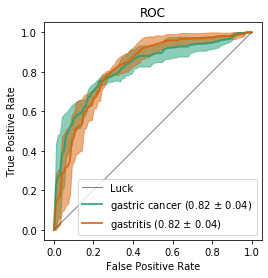

In [31]:
res,d=classification(exp_ggf,field='Diagnosis',col='all')
plot_roc(res)

In [32]:
datasets=['PRJEB26931',
    "PRJNA375772_Xi_an",'PRJNA375772_Inner_Mongolia','PRJNA481413']
expDS=[D26931f,D375772f_xian,D375772f_im,D481413f]

In [33]:
expDS

[AmpliconExperiment with 125 samples, 44 features,
 AmpliconExperiment with 94 samples, 44 features,
 AmpliconExperiment with 92 samples, 44 features,
 AmpliconExperiment with 230 samples, 44 features]

In [34]:

auc_df=pd.DataFrame(columns=datasets+['Average'],index=datasets+['Average'])
with PdfPages('figures/onestudy_predict_another_ROC_cruve_withhp.pdf') as pdf:
    for ds1,ds2 in permutations(expDS,2):
        ds1_name=ds1.sample_metadata['Study'][0]
        ds2_name= ds2.sample_metadata['Study'][0]
        res1,res2,_=OTO_RFC(ds1,ds2)
        auc_df.loc[ds1_name,ds1_name]=ca_roc(res1,cv=True)
        auc_df.loc[ds1_name,ds2_name]=ca_roc(res2,cv=False)
        #plot_roc(res1,title=ds1_name,classes=['gastric cancer'])
        plot_roc(res2,title=ds1_name+' predict '+ds2_name,classes=['gastric cancer'])
        pdf.savefig()
        plt.close()

/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selec

In [35]:
auc_df['Average']=auc_df.mean(axis=1)
auc_df.loc['Average']=auc_df.mean()
auc_df.loc['Average','Average']=np.diagonal(auc_df)[:-1].mean()
auc_df

,PRJEB26931,PRJNA375772_Xi_an,PRJNA375772_Inner_Mongolia,PRJNA481413,Average
PRJEB26931,0.994949,0.644444,0.723214,0.708658,0.767817
PRJNA375772_Xi_an,0.639518,0.826961,0.703125,0.68155,0.712788
PRJNA375772_Inner_Mongolia,0.75842,0.763889,0.747505,0.680038,0.737463
PRJNA481413,0.733304,0.743519,0.741319,0.802442,0.755146
Average,0.781548,0.744703,0.728791,0.718172,0.842964


/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/sklearn/model_selec

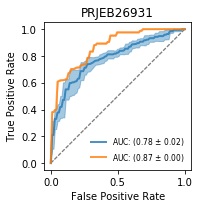

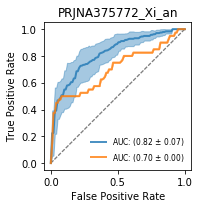

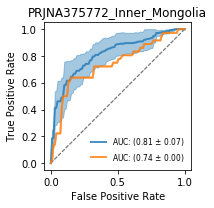

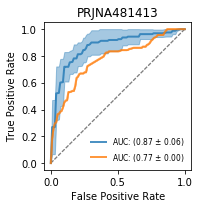

In [36]:
# diff feature leave one study out classification
roc_l=[]
with PdfPages('figures/leave_onestudy_ROC_cruve_withhp-diff-feature.pdf') as pdf:
    for ds,expds in zip(datasets,expDS):
        expe=exp_ggf.filter_samples('Study',ds,negate=True)

        res1,res2,_=OTO_RFC(expe,expds)  
        #plot_roc(res1,title=ds,classes=['gastric cancer'])
        roc_value=ca_roc(res2,cv=False)
        roc_l.append(roc_value)
        
        
        fig, ax = plt.subplots(figsize=(3,3))
        for dataset,c in zip([res1,res2],cmap.colors[:2]):

            plot_roc_curve2(dataset,
                        title=ds,col=c,
                        classes=['gastric cancer'],ax=ax)

        plt.tight_layout()    
        pdf.savefig()

In [37]:
roc_df2=pd.DataFrame(index=datasets,data=roc_l)
roc_df2=roc_df2.T
roc_df2['Average']=roc_df2.mean(axis=1)

roc_df2['type']='LOO'
roc_df2.index=['Leave one cohort out']
roc_df2

,PRJEB26931,PRJNA375772_Xi_an,PRJNA375772_Inner_Mongolia,PRJNA481413,Average,type
Leave one cohort out,0.87108,0.70463,0.739583,0.774367,0.772415,LOO


/home/liyan/.conda/envs/qiime2-2020.2/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


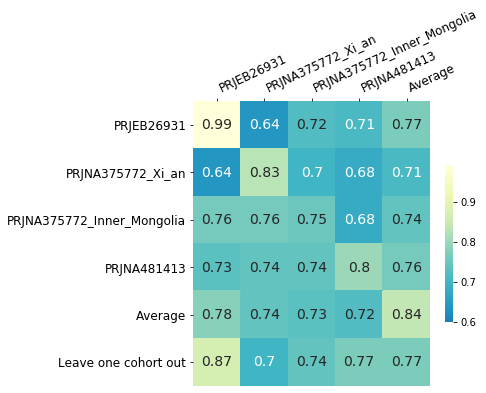

In [38]:
datap=pd.concat([auc_df,roc_df2])
fig,ax=plt.subplots(figsize=(7,7),sharex=True)

data=datap[datasets+['Average']]
data=pd.DataFrame(columns=data.columns,index=data.index,data=data.values.astype(float)).round(2)

sns.heatmap(data, vmin=0.6,annot=True, fmt='',cmap='YlGnBu_r',center=0.7,cbar=True,square=True,
            cbar_kws={"shrink": 0.4 },
               annot_kws={'size':14},ax=ax)


ax.xaxis.tick_top() 
ax.xaxis.set_label_position('top')
plt.setp(ax.get_xticklabels(), rotation=25, ha='left',size=12)
plt.setp(ax.get_yticklabels(),size=12)
plt.tight_layout()